# Supervised Random Forest Analysis
This notebook demonstrates the use of a supervised Random Forest model for classification tasks. It includes data preprocessing, handling class imbalance, model training, cross-validation, and evaluation of performance metrics.

In [148]:
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, matthews_corrcoef, auc, average_precision_score
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Data Preprocessing
This section preprocesses the training and testing datasets by handling missing values and separating features from the target variable.

In [149]:
# Run the dataInfo notebook to preprocess the data
%run dataInfo.ipynb

# Load the train and test datasets
cleanTrain = train_df.dropna()  # Drop missing values in training data
cleanTest = test_df.dropna()  # Drop missing values in test data


# Preprocess the train dataset
X = cleanTrain.drop(columns=['Class/ASD'])
y = cleanTrain['Class/ASD']



Dropped low-variance features: ['relation_4.0', 'relation_5.0', 'ethnicity_Turkish', 'ethnicity_others', 'country_of_res_AmericanSamoa', 'country_of_res_Angola', 'country_of_res_Argentina', 'country_of_res_Armenia', 'country_of_res_Aruba', 'country_of_res_Azerbaijan', 'country_of_res_Bahamas', 'country_of_res_Bangladesh', 'country_of_res_Belgium', 'country_of_res_Bolivia', 'country_of_res_Burundi', 'country_of_res_China', 'country_of_res_Cyprus', 'country_of_res_Czech Republic', 'country_of_res_Egypt', 'country_of_res_Ethiopia', 'country_of_res_Germany', 'country_of_res_Hong Kong', 'country_of_res_Iceland', 'country_of_res_Iran', 'country_of_res_Iraq', 'country_of_res_Italy', 'country_of_res_Japan', 'country_of_res_Malaysia', 'country_of_res_Mexico', 'country_of_res_Nicaragua', 'country_of_res_Niger', 'country_of_res_Oman', 'country_of_res_Pakistan', 'country_of_res_Romania', 'country_of_res_Russia', 'country_of_res_Saudi Arabia', 'country_of_res_Serbia', 'country_of_res_Sierra Leone',

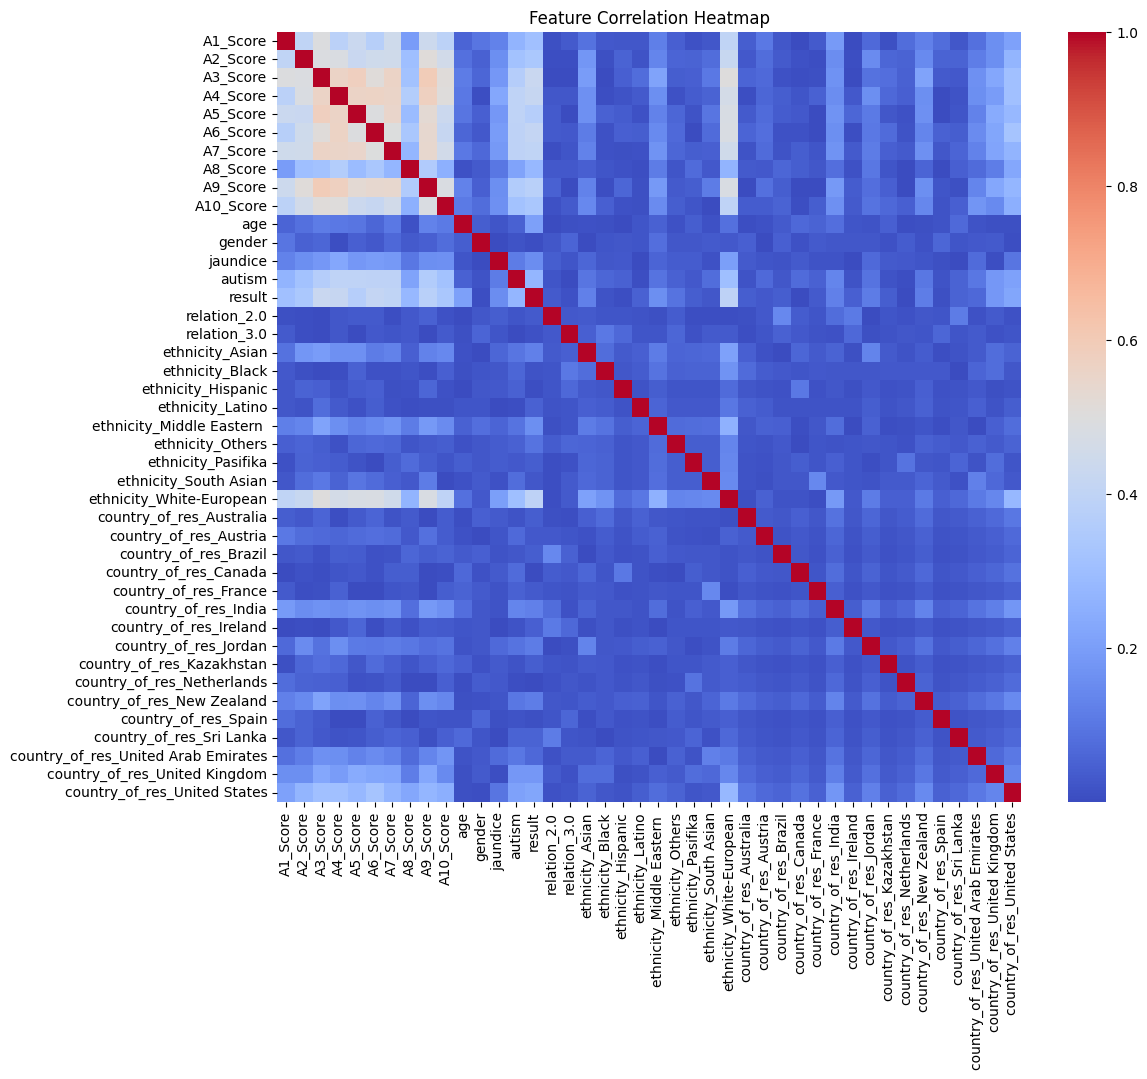

Highly correlated features to drop: []
                                Feature       Score
5                              A6_Score  333.690462
3                              A4_Score  267.487510
8                              A9_Score  218.159831
25             ethnicity_White-European  217.207738
4                              A5_Score  216.279628
2                              A3_Score  215.273204
6                              A7_Score  205.281116
1                              A2_Score  128.759286
13                               autism  118.227076
14                               result  112.790540
41         country_of_res_United States  112.078853
9                             A10_Score  106.920571
7                              A8_Score   86.295342
0                              A1_Score   79.197664
31                 country_of_res_India   24.016591
40        country_of_res_United Kingdom   21.884468
36           country_of_res_New Zealand   19.507431
12                       

In [150]:


# Set a low threshold (e.g., near 0) to filter out near-constant features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)

# Get the mask of features that are kept
keep_mask = selector.get_support()

# Get names of dropped features
dropped_low_variance = X.columns[~keep_mask]
print("Dropped low-variance features:", dropped_low_variance.tolist())

# Drop from your data
X_train_reduced = X.loc[:, keep_mask]

# Compute correlation matrix
corr_matrix = X_train_reduced.corr().abs()

# Plot heatmap if desired
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Highly correlated features to drop:", to_drop)

X_train_final = X_train_reduced.drop(columns=to_drop)


# Run feature selection
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_final, y)

# Create a dataframe of scores
feature_scores = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

print(feature_scores)

selector_top = SelectKBest(score_func=f_classif, k=20)
X_best = selector_top.fit_transform(X_train_final, y)

X = X_best

# Handle Class Imbalance and Define Model
This section applies SMOTE to address class imbalance and defines the Random Forest model with optimal parameters.

In [151]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
#X_resampled, y_resampled = smote.fit_resample(X, y)

# Define the Random Forest model with the best parameters
rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=40,
    class_weight='balanced',
    random_state=42
)


# Define stratified 10-fold CV with 3 repeats
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=12)


# Initialize Metrics
This section initializes lists to store evaluation metrics and aggregated precision-recall data.

In [152]:

imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Initialize lists to store metrics
roc_auc_scores = []
pr_auc_scores = []
f1_scores = []
mcc_scores = []

# Initialize lists to store aggregated precision and recall
all_precision = []
all_recall = []
PR_curve_list = []


X_train_main, X_holdout, y_train_main, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Cross-Validation and Model Training
This section performs stratified cross-validation, trains the model, and calculates evaluation metrics for each fold.

In [ ]:
for train_idx, val_idx in cv.split(X_train_main, y_train_main):
    # Split the original (unbalanced) data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Preprocessing
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Apply SMOTE only to training fold
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Train the model
    rf_model.fit(X_resampled, y_resampled)

    # Make predictions
    y_val_pred = rf_model.predict(X_val)
    y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
    pr_auc = np.trapz(recall, precision)
    f1 = f1_score(y_val, y_val_pred)
    mcc = matthews_corrcoef(y_val, y_val_pred)

    # Append metrics
    roc_auc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)
    f1_scores.append(f1)
    mcc_scores.append(mcc)
    all_precision.append(precision)
    all_recall.append(recall)
    PR_curve_list.append((precision, recall))


# Test Data Preprocessing and Predictions
This section preprocesses the test dataset, aligns it with the training data, and makes predictions using the trained model.

In [154]:
# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Align test data columns with training data columns, excluding the target column
# Ensure X_resampled is a DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train_final.columns[:X_resampled.shape[1]])

# Align test data columns with training data columns, excluding the target column
X_test = cleanTest[X_resampled_df.columns.intersection(cleanTest.columns)]

X_train_processed = imputer.fit_transform(X_resampled)
X_train_processed = scaler.fit_transform(X_train_processed)

X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

# Align test data columns with training data columns, excluding the target column
X_test = pd.DataFrame(X_test, columns=X_resampled_df.columns)

test_predictions = rf_model.predict(X_test)
test_probabilities = rf_model.predict_proba(X_test)[:, 1]

# 9. Add predictions to test set
cleanTest_with_predictions = cleanTest.copy()
cleanTest_with_predictions['Predicted_Class'] = test_predictions
cleanTest_with_predictions['Probability'] = test_probabilities


<Figure size 1000x600 with 0 Axes>

In [155]:

# Step 2: Fit preprocessing ONLY on training set
X_train_proc = imputer.fit_transform(X_train_main)
X_holdout_proc = imputer.transform(X_holdout)

X_train_proc = scaler.fit_transform(X_train_proc)
X_holdout_proc = scaler.transform(X_holdout_proc)

# Step 3: Apply SMOTE only to training data
X_resampled_final, y_resampled_final = smote.fit_resample(X_train_proc, y_train_main)


# Step 4: Train final model
rf_model.fit(X_resampled_final, y_resampled_final)

# Step 5: Predict on untouched holdout
y_holdout_pred = rf_model.predict(X_holdout_proc)
y_holdout_proba = rf_model.predict_proba(X_holdout_proc)[:, 1]

# Step 6: Compute metrics
final_roc_auc = roc_auc_score(y_holdout, y_holdout_proba)
final_pr_auc = average_precision_score(y_holdout, y_holdout_proba)
final_f1 = f1_score(y_holdout, y_holdout_pred)
final_mcc = matthews_corrcoef(y_holdout, y_holdout_pred)


# Aggregate Precision-Recall Curves and Calculate Metrics
This section aggregates precision-recall curves, calculates the area under the curve, and computes confidence intervals for evaluation metrics.

In [156]:
# Aggregate precision-recall curves
mean_precision = np.linspace(0, 1, 100)
mean_recall = np.zeros_like(mean_precision)

for precision, recall in zip(all_precision, all_recall):
    mean_recall += np.interp(mean_precision, np.flip(recall), np.flip(precision))
mean_recall /= len(all_precision)

# Calculate the area under the aggregated curve
pr_auc = auc(mean_precision, mean_recall)

# Calculate mean and confidence intervals for each metric
def calculate_ci(scores):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    ci_lower = mean_score - 1.96 * std_score / np.sqrt(len(scores))
    ci_upper = mean_score + 1.96 * std_score / np.sqrt(len(scores))
    return mean_score, ci_lower, ci_upper

mean_roc_auc, ci_lower_roc_auc, ci_upper_roc_auc = calculate_ci(roc_auc_scores)
mean_pr_auc, ci_lower_pr_auc, ci_upper_pr_auc = calculate_ci(pr_auc_scores)
mean_f1, ci_lower_f1, ci_upper_f1 = calculate_ci(f1_scores)
mean_mcc, ci_lower_mcc, ci_upper_mcc = calculate_ci(mcc_scores)

# Plot and Print Results
This section plots the precision-recall curves and prints the evaluation metrics with confidence intervals.


Final Model Performance on Holdout Set:
ROC-AUC: 0.8800
PR-AUC: 0.6088
F1 Score: 0.6269
Matthews Correlation Coefficient: 0.5292
Mean ROC-AUC: 0.8789447762349586 (95% CI: 0.8587978578556381, 0.8990916946142791)
Mean PR-AUC: 0.4433733757782592 (95% CI: 0.39388980158421294, 0.49285694997230545)
Mean F1 Score: 0.5344895366119495 (95% CI: 0.5000673057978129, 0.5689117674260862)
Mean Matthews Correlation Coefficient: 0.4496235907627624 (95% CI: 0.4079931265148692, 0.49125405501065567)


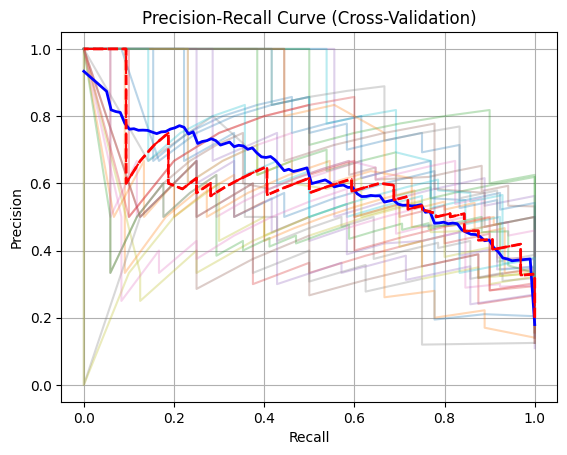

In [157]:
# Print results
for i, (precision, recall) in enumerate(PR_curve_list):
    plt.plot(recall, precision, alpha=0.3, label=f'Fold {i+1} PR Curve')
# Plot the aggregated curve
plt.plot(mean_precision, mean_recall, color='blue', lw=2, label=f'Average PR Curve (AUC = {pr_auc:.2f})')

final_precision, final_recall, _ = precision_recall_curve(y_holdout, y_holdout_proba)
final_avg_precision = average_precision_score(y_holdout, y_holdout_proba)

plt.plot(final_recall, final_precision, linestyle='--', color='red',
         label=f'Final Model PR (AUC={final_avg_precision:.2f})')

plt.plot(final_recall, final_precision, linestyle='--', color='red', lw=2,
         label=f'Final Model PR (AUC={final_avg_precision:.2f})')

# Add labels and legend
plt.title('Precision-Recall Curve (Cross-Validation)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

final_roc_auc = roc_auc_score(y_holdout, y_holdout_proba)
final_pr_auc = average_precision_score(y_holdout, y_holdout_proba)
final_f1 = f1_score(y_holdout, y_holdout_pred)
final_mcc = matthews_corrcoef(y_holdout, y_holdout_pred)

print("\nFinal Model Performance on Holdout Set:")
print(f"ROC-AUC: {final_roc_auc:.4f}")
print(f"PR-AUC: {final_pr_auc:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"Matthews Correlation Coefficient: {final_mcc:.4f}")

print(f"Mean ROC-AUC: {mean_roc_auc} (95% CI: {ci_lower_roc_auc}, {ci_upper_roc_auc})")
print(f"Mean PR-AUC: {mean_pr_auc} (95% CI: {ci_lower_pr_auc}, {ci_upper_pr_auc})")
print(f"Mean F1 Score: {mean_f1} (95% CI: {ci_lower_f1}, {ci_upper_f1})")
print(f"Mean Matthews Correlation Coefficient: {mean_mcc} (95% CI: {ci_lower_mcc}, {ci_upper_mcc})")